<a href="https://colab.research.google.com/github/bugristaya/comp_ling/blob/main/bykova_vectors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gensim # скачиваем gensim

In [ ]:
import re
import gensim
import gensim.downloader as api
from gensim import corpora
from gensim.models import TfidfModel
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns # импортируем все необходимое

1. Скачать [датасет по ссылке](https://raw.githubusercontent.com/tyqiangz/multilingual-sentiment-datasets/refs/heads/main/data/english/test.csv) (просто запустить строку ниже)

In [ ]:
!wget https://raw.githubusercontent.com/tyqiangz/multilingual-sentiment-datasets/refs/heads/main/data/english/test.csv

--2025-11-03 14:28:02--  https://raw.githubusercontent.com/tyqiangz/multilingual-sentiment-datasets/refs/heads/main/data/english/test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 102826 (100K) [text/plain]
Saving to: ‘test.csv’

test.csv            100%[===================>] 100.42K  --.-KB/s    in 0.01s   

2025-11-03 14:28:02 (8.34 MB/s) - ‘test.csv’ saved [102826/102826]



2. Открыть csv и сохранить текст в переменную (макс. балл == 1)

In [ ]:
import pandas as pd
df = pd.read_csv(r'/content/test.csv')

3. Извлечь столбец с текстами (макс. балл == 1)

In [ ]:
texts = df['text'].tolist() # не знаю, насколько это правильно, потому что на консультацию я не смогла прийти, а записи не было.....

4. Построить Bag-of-Words (макс. балл == 3)

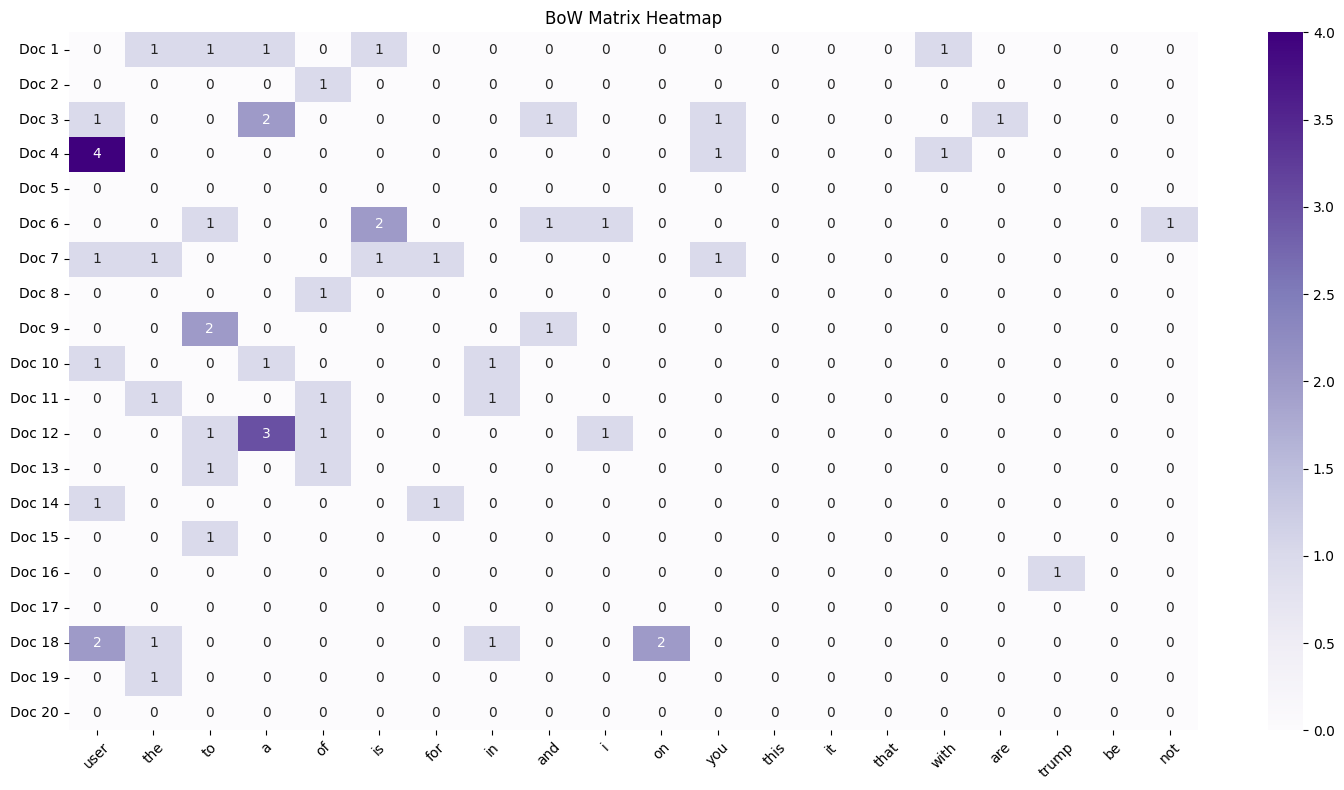

In [ ]:
# Задача 1.1: Создайте словарь и BoW представление (макс. балл == 2)

tokenized_docs = [t.lower().split() for t in texts] # Приводим тексты к нижнему регистру

cleaned_docs = [] # Создаем пустой список для удаления знаков препинания
for doc in tokenized_docs: # Проходимся по каждоиу элементу списка
    cleaned_doc = [re.sub(r'[^\w\s]', '', word) for word in doc] # Удаляем знаки препинания
    cleaned_doc = [word for word in cleaned_doc if word] # Убираем пустые строки
    cleaned_docs.append(cleaned_doc) # Добавляем очищенные данные в список

tokenized_docs = cleaned_docs # Присваиваем переменной очищенный текст

dictionary = corpora.Dictionary(tokenized_docs) # Строим словарь по очищенным данным

bow_corpus = [dictionary.doc2bow(doc) for doc in tokenized_docs] # Преобразуйем документы в BoW векторы


# Задача 1.2: Визуализируйте результаты (макс. балл == 1)
# Cоздаем таблицу частот слов
word_freq = {}  # Создаем пустой словарь для подсчета частот

# Проходим по каждому документу в bow_corpus и считаем частоту
for doc in bow_corpus:
    for idx, freq in doc:
        word = dictionary[idx]
        word_freq[word] = word_freq.get(word, 0) + freq

top_words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:20] # Сортируем слова по частоте и берем 20 самых частотных

def bow_to_dense(bow_corpus, dictionary): # С помощью функции преобразуем bow_corpus в обычную матрицу
    dense_vectors = [] # Пустой список для плотных векторов

    for doc in bow_corpus: # Проходим по каждому документу
        dense_vec = [0] * len(dictionary)

        for idx, freq in doc:
            dense_vec[idx] = freq # На позицию idx ставим частоту

        dense_vectors.append(dense_vec) # Добавляем созданный плотный вектор документа в общий список

    return dense_vectors # Возвращаем список с векторами

dense_vectors = bow_to_dense(bow_corpus, dictionary) # Преобразовываем bow_corpus в обычную матрицу

matrix = np.array(dense_vectors[:20]) # Отбираем 20 документов для посторения визулизации

top_word_ids = [dictionary.token2id[word] for word, _ in top_words[:20]] # Находим самые частые 20 слов в корпусе для визуализации

# Выбираем из матрицы только столбцы с топ-словами
matrix_subset = matrix[:, top_word_ids] # Определяем размер матрицы 20 документов × 20 слов

# Создаем heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(matrix_subset,
            annot=True,
            fmt='d',
            xticklabels=[word for word, _ in top_words[:20]],  # Подписи осей X
            yticklabels=[f'Doc {i+1}' for i in range(20)],     # Подписи осей Y
            cmap='Purples')  # Выбираем цвет для визуализации
plt.title('BoW Matrix Heatmap')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



5. Построить TF-IDF (макс. балл == 5)

In [65]:
# Задача 2.1: Примените TF-IDF к BoW представлению (макс. балл == 2)

# Используем TfidfModel из gensim
tfidf_model = TfidfModel(bow_corpus)
tfidf_corpus = tfidf_model[bow_corpus]

# Выводим TF-IDF векторы для каждого документа
for i, doc_vec in enumerate(tfidf_corpus, 1):
    print(f"Документ {i}: {[(dictionary[idx], round(score, 3)) for idx, score in doc_vec]}")

# Задача 2.2: Проанализируем веса TF-IDF (макс. балл == 3)

def analyze_tfidf_components(bow_corpus, dictionary):
    # Шаг 1: Создаем матрицу TF (term frequency)
    tf_matrix = np.zeros((len(bow_corpus), len(dictionary)))
    for doc_idx, doc in enumerate(bow_corpus):
        for word_idx, freq in doc:
            tf_matrix[doc_idx, word_idx] = freq

    # Шаг 2: Вычисляем DF (document frequency)
    df_vector = np.sum(tf_matrix > 0, axis=0)  # Количество документов с каждым словом

    # Шаг 3: Вычисляем IDF (inverse document frequency)
    N = len(bow_corpus)  # общее количество документов
    idf_vector = np.log(N / (df_vector + 1)) + 1

    # Шаг 4: Вычисляем TF-IDF вручную
    tfidf_manual = tf_matrix * idf_vector

    return tf_matrix, df_vector, idf_vector, tfidf_manual

tf_matrix, df_vector, idf_vector, tfidf_manual = analyze_tfidf_components(bow_corpus, dictionary) # Эту строку сгенировал ИИ, к сожалению, я не поняла зачем она...

df_results = [] # Создаем пустой словарь для записи результатов
for word_id in range(len(dictionary)): # Проходимся по каждому слову
    word = dictionary[word_id]

    # Считаем TF
    tf_total = np.sum(tf_matrix[:, word_id])

    # Считаем DF
    df = df_vector[word_id]

    # Считаем IDF
    idf = idf_vector[word_id]

    # Считаем TF-IDF
    tfidf_values = tfidf_manual[:, word_id]
    # Берем только ненулевые значения (где слово встречается). Тоже с помощью ИИ
    non_zero_tfidf = tfidf_values[tfidf_values > 0]
    avg_tfidf = np.mean(non_zero_tfidf) if len(non_zero_tfidf) > 0 else 0

    df_results.append({
        'word': word,
        'tf_total': tf_total,
        'df': df,
        'idf': round(idf, 4),
        'tf-idf': round(avg_tfidf, 4)
    }) # Записываем все в словарь

# Создаем DataFrame для сохранения результатов
tfidf_df = pd.DataFrame(df_results)

# Сохраняем результат в *.csv
tfidf_df.to_csv('vectors.csv', index=False, encoding='utf-8-sig')


Документ 1: [('a', np.float64(0.078)), ('about', np.float64(0.163)), ('caveman', np.float64(0.35)), ('conversation', np.float64(0.35)), ('dad', np.float64(0.314)), ('ever', np.float64(0.257)), ('have', np.float64(0.149)), ('infuriating', np.float64(0.35)), ('is', np.float64(0.087)), ('most', np.float64(0.21)), ('my', np.float64(0.149)), ('pointless', np.float64(0.35)), ('the', np.float64(0.056)), ('thing', np.float64(0.236)), ('to', np.float64(0.069)), ('trying', np.float64(0.293)), ('vegetarianism', np.float64(0.226)), ('with', np.float64(0.132))]
Документ 2: [('4', np.float64(0.238)), ('altright', np.float64(0.281)), ('at', np.float64(0.162)), ('israel', np.float64(0.234)), ('latestnews', np.float64(0.369)), ('nativeamerican', np.float64(0.369)), ('newmexico', np.float64(0.369)), ('of', np.float64(0.086)), ('palestine', np.float64(0.256)), ('politics', np.float64(0.309)), ('protesting', np.float64(0.331)), ('rise', np.float64(0.309))]
Документ 3: [('a', np.float64(0.195)), ('and', np

##### **Как вычислить компоненты вручную**

```python
def analyze_tfidf_components(bow_corpus, dictionary):
    # Шаг 1: Создаем матрицу TF (term frequency)
    tf_matrix = np.zeros((len(bow_corpus), len(dictionary)))
    for doc_idx, doc in enumerate(bow_corpus):
        for word_idx, freq in doc:
            tf_matrix[doc_idx, word_idx] = freq
    
    # Шаг 2: Вычисляем DF (document frequency)
    df_vector = np.sum(tf_matrix > 0, axis=0)  # Количество документов с каждым словом
    
    # Шаг 3: Вычисляем IDF (inverse document frequency)
    N = len(bow_corpus)  # общее количество документов
    idf_vector = np.log(N / (df_vector + 1)) + 1
    
    # Шаг 4: Вычисляем TF-IDF вручную
    tfidf_manual = tf_matrix * idf_vector
    
    return tf_matrix, df_vector, idf_vector, tfidf_manual
```

6. Произвести сравните

*Эта часть не оценивается, но будет давать доп. баллы на экзамене для тех, кто выполнит её*

In [ ]:
# Сравните BoW и TF-IDF для конкретных слов
# - Выберите 3-4 слова из датасета (выберите слова, характерные для датасета)
# - Постройте графики сравнения их весов в BoW и TF-IDF

##### **Как построить сравнительный график**
```python
def compare_bow_tfidf(words, bow_dense, tfidf_dense, dictionary):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    for i, word in enumerate(words):
        row, col = i // 2, i % 2
        word_id = dictionary.token2id[word]
        
        # Веса для этого слова во всех документах
        bow_weights = [doc[word_id] for doc in bow_dense]
        tfidf_weights = [doc[word_id] for doc in tfidf_dense]
        
        x = range(len(bow_dense))
        axes[row, col].bar(x, bow_weights, alpha=0.7, label='BoW', width=0.4)
        axes[row, col].bar([p + 0.4 for p in x], tfidf_weights, alpha=0.7, label='TF-IDF', width=0.4)
        axes[row, col].set_title(f'Сравнение весов: "{word}"')
        axes[row, col].legend()
        axes[row, col].set_xticks([p + 0.2 for p in x])
        axes[row, col].set_xticklabels([f'Док {i+1}' for i in x])
    
    plt.tight_layout()
    plt.show()
```